# Data Sources

Get data 

## import

In [113]:
import os
import sys
import time
import datetime

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
#import yfinance as yf
import ccxt

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



## definitions

In [114]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2021-01-01 00:00:00"
LAST_DATE =  "2023-02-13 00:00:00"
TIMEFRAME = "1h"

path_save_df_eth = "data/df_eth.csv"
path_save_df_eth_2 = "data/df_eth_2.csv"
path_save_df_btc = "data/df_btc.csv"
path_save_df_btc_2 = "data/df_btc_2.csv"
path_save_df_bnb = "data/df_bnb.csv"
path_save_df_bnb_2 = "data/df_bnb_2.csv"

## Download data

In [115]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE



# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp)
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            from_timestamp += len(ohlcvs) * hour
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms')

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except:
        
        return False

def fill_time_gap(df_in, df_2):
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):

            delta_min = df["Time"].diff().value_counts().index[0]
            df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
            df.index = df["nb_time"].values

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df
            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df


In [116]:
data_ok = check_data()
print(data_ok)

True


In [117]:
if not data_ok:
    exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
    })

    
    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        FIRST_DATE,  
        LAST_DATE,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:
    # simply reload from disk
    df_eth = pd.read_csv(path_save_df_eth)
    df_btc = pd.read_csv(path_save_df_btc)
    df_bnb = pd.read_csv(path_save_df_bnb)

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

df_eth:  (18569, 7)
df_btc:  (18569, 7)
df_bnb:  (18569, 7)


In [119]:

data_ok_2 = check_data_2()

if not data_ok_2:

    kucoin = ccxt.kucoin({
        'rateLimit': 1,
        'enableRateLimit': True,
    })

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    # simply reload from disk
    df_eth_2 = pd.read_csv(path_save_df_eth_2)
    df_btc_2 = pd.read_csv(path_save_df_btc_2)
    df_bnb_2 = pd.read_csv(path_save_df_bnb_2)   

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



df_eth kucoin:  (18571, 7)
df_btc kucoin:  (18571, 7)
df_bnb kucoin:  (18571, 7)


In [151]:
df_eth = fill_time_gap(df_eth, df_eth_2)
df_btc = fill_time_gap(df_btc, df_btc_2)
df_bnb = fill_time_gap(df_bnb, df_bnb_2)

In [152]:
df_bnb

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,37.3596,37.4423,36.9636,37.3764,95113.8260,2021-01-01 00:00:00
1,1609462800000,37.3765,37.9390,37.3353,37.6134,152336.8820,2021-01-01 01:00:00
2,1609466400000,37.6134,37.9730,37.5758,37.9600,107655.6440,2021-01-01 02:00:00
3,1609470000000,37.9600,38.1000,37.7551,37.9250,116381.5910,2021-01-01 03:00:00
4,1609473600000,37.9240,38.0765,37.8300,37.8702,63709.8140,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18566,1676296800000,289.3000,292.4000,287.7000,292.0000,67111.4220,2023-02-13 14:00:00
18567,1676300400000,292.0000,292.1000,286.2000,286.8000,40541.3230,2023-02-13 15:00:00
18568,1676304000000,286.9000,288.2000,285.3000,286.2000,24613.4820,2023-02-13 16:00:00
18569,1676307600000,284.6370,286.7730,283.1300,285.0980,3829.2454,2023-02-13 17:00:00


In [153]:
df_bnb["Time"].diff().value_counts()

3600000.0    18570
Name: Time, dtype: int64

In [75]:
delta_min = df_eth["Time"].diff().value_counts().index[0]
df_eth["nb_time"] = ((df_eth["Time"] - df_eth["Time"].values[0]) / delta_min).astype(np.int64)
df_eth.index = df_eth["nb_time"].values
df_eth

0        1609459200000
1        1609462800000
2        1609466400000
3        1609470000000
4        1609473600000
             ...      
18564    1676289600000
18565    1676293200000
18566    1676296800000
18567    1676300400000
18568    1676304000000
Name: Time, Length: 18556, dtype: int64

In [ ]:
df_test = df_eth_2.copy()
df_test.loc[df_eth.index] = df_eth.copy()
df_test

In [ ]:
def fill_time_gap(df, df_2):
    if not test_time_continuity(df):
        pass
        

    else:
        return df

In [73]:
df_eth.drop_duplicates(subset=['Time'], inplace=True)

In [74]:
df_eth["Time"].diff().value_counts()

3600000.0     18549
7200000.0         2
10800000.0        2
14400000.0        1
18000000.0        1
Name: Time, dtype: int64

In [105]:
delta_min = df_eth["Time"].diff().value_counts().index[0]
df_eth["nb_time"] = ((df_eth["Time"] - df_eth["Time"].values[0]) / delta_min).astype(np.int64)
df_eth.index = df_eth["nb_time"]
df_eth

,Time,Open,High,Low,Close,Volume,date,nb_time
nb_time,,,,,,,,
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,0
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,1
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,3
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,4
...,...,...,...,...,...,...,...,...
18564,1676289600000,1486.07,1491.89,1484.06,1487.32,19492.91240,2023-02-13 12:00:00,18564
18565,1676293200000,1487.31,1488.80,1477.66,1477.98,28307.80350,2023-02-13 13:00:00,18565
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.36010,2023-02-13 14:00:00,18566


In [89]:
df_eth["Time"].diff().value_counts()

3600000.0     18549
7200000.0         2
10800000.0        2
14400000.0        1
18000000.0        1
Name: Time, dtype: int64

In [93]:
diff_time = df_eth["Time"].diff()
df_eth.loc[np.argmax(diff_time)+4:np.argmax(diff_time)+10]

,Time,Open,High,Low,Close,Volume,date,nb_time
5375,1628809200000,2999.00,3049.55,2998.99,3045.96,23688.80488,2021-08-12 23:00:00,5375
5376,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.11420,2021-08-13 00:00:00,5376
5377,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.03514,2021-08-13 01:00:00,5377
5378,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.16757,2021-08-13 06:00:00,5382
5379,1628838000000,3184.53,3231.83,3184.53,3222.99,58228.69375,2021-08-13 07:00:00,5383
5380,1628841600000,3222.99,3251.20,3216.43,3234.95,47701.08929,2021-08-13 08:00:00,5384
5381,1628845200000,3234.96,3249.00,3221.30,3225.38,26186.31119,2021-08-13 09:00:00,5385


In [97]:
list_index = list(set(list(range(df_eth["nb_time"].values[-1]))) - set(list(df_eth["nb_time"].values)))
list_index

[1538, 5378, 5379, 5380, 5381, 6511, 6512, 2741, 2742, 2743, 2618, 2619, 988]

In [102]:
delta_min = df_eth_2["Time"].diff().value_counts().index[0]
df_eth_2["nb_time"] = ((df_eth_2["Time"] - df_eth_2["Time"].values[0]) / delta_min).astype(np.int64)

,Time,Open,High,Low,Close,Volume,date,nb_time
0,1609459200000,736.14,738.80,729.61,734.06,583.786719,2021-01-01 00:00:00,0
1,1609462800000,734.03,748.88,733.44,748.70,1262.473819,2021-01-01 01:00:00,1
2,1609466400000,748.31,748.90,742.27,744.20,883.894157,2021-01-01 02:00:00,2
3,1609470000000,744.03,747.18,743.32,744.86,403.482930,2021-01-01 03:00:00,3
4,1609473600000,745.36,747.05,739.73,742.50,644.383020,2021-01-01 04:00:00,4
...,...,...,...,...,...,...,...,...
18566,1676296800000,1478.04,1489.00,1477.85,1488.63,1901.201149,2023-02-13 14:00:00,18566
18567,1676300400000,1488.63,1489.59,1475.41,1475.76,1518.672390,2023-02-13 15:00:00,18567
18568,1676304000000,1475.76,1487.60,1461.77,1475.58,3563.238761,2023-02-13 16:00:00,18568
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,18569


In [103]:
df_eth[df_eth["nb_time"] == list_index[0]]

,Time,Open,High,Low,Close,Volume,date,nb_time


In [104]:
df_eth_2[df_eth_2["nb_time"] == list_index[0]]

,Time,Open,High,Low,Close,Volume,date,nb_time
1538,1614996000000,1534.36,1539.28,1520.55,1535.86,1700.273961,2021-03-06 02:00:00,1538


In [109]:
df_test = df_eth_2.copy()
df_test.loc[df_eth.index] = df_eth.copy()
df_test

,Time,Open,High,Low,Close,Volume,date,nb_time
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,0
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,1
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,3
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,4
...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,18566
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,18567
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,18568
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,18569


In [110]:
df_test["Time"].diff().value_counts()

3600000.0    18570
Name: Time, dtype: int64

In [111]:
df_test.head(10)

,Time,Open,High,Low,Close,Volume,date,nb_time
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,0
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,1
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,3
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,4
5,1609477200000,742.34,743.23,739.50,740.65,14948.26447,2021-01-01 05:00:00,5
6,1609480800000,740.72,743.25,737.04,739.97,17106.99495,2021-01-01 06:00:00,6
7,1609484400000,739.87,740.51,734.40,737.38,21624.68945,2021-01-01 07:00:00,7
8,1609488000000,737.37,738.48,725.10,730.07,52992.04892,2021-01-01 08:00:00,8
9,1609491600000,730.07,734.77,728.77,733.68,22836.46973,2021-01-01 09:00:00,9


In [112]:
df_eth.head(10)

,Time,Open,High,Low,Close,Volume,date,nb_time
nb_time,,,,,,,,
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,0
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,1
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,3
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,4
5,1609477200000,742.34,743.23,739.50,740.65,14948.26447,2021-01-01 05:00:00,5
6,1609480800000,740.72,743.25,737.04,739.97,17106.99495,2021-01-01 06:00:00,6
7,1609484400000,739.87,740.51,734.40,737.38,21624.68945,2021-01-01 07:00:00,7
8,1609488000000,737.37,738.48,725.10,730.07,52992.04892,2021-01-01 08:00:00,8


In [61]:

if not test_time_continuity(df_eth):
    # take data from data 2
    


False

In [62]:
test_time_continuity(df_eth_2)

True

In [57]:
df_btc_2.shape

(18571, 7)

## Tests

In [10]:
assert df_eth.shape[0] == df_eth.dropna().shape[0], "Some data are NaN !"
diff_time = np.diff(
    np.array( 
        (df_eth["date"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1h') 
    )
)
assert np.max(diff_time) == np.min(diff_time), "Time gap!"

assert df_btc.shape[0] == df_btc.dropna().shape[0], "Some data are NaN !"
diff_time = np.diff(
    np.array( 
        (df_btc["date"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1h') 
    )
)
assert np.max(diff_time) == np.min(diff_time)

assert df_bnb.shape[0] == df_bnb.dropna().shape[0], "Some data are NaN !"
diff_time = np.diff(
    np.array( 
        (df_bnb["date"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1h') 
    )
)
assert np.max(diff_time) == np.min(diff_time)

AssertionError: Time gap!

In [87]:
df_eth.loc[np.argmax(diff_time)-4:np.argmax(diff_time)+4]

,Time,Open,High,Low,Close,Volume,date,nb_time
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,0
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,1
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,3
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,4


In [17]:
df_btc.loc[np.argmax(diff_time)-4:np.argmax(diff_time)+4]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,44474.96,44538.00,44142.00,44242.13,1127.548195,2021-08-12 21:00:00
5374,1628805600000,44242.13,44295.38,43855.88,43954.59,1451.940047,2021-08-12 22:00:00
5375,1628809200000,43954.42,44535.99,43948.38,44399.00,1753.367677,2021-08-12 23:00:00
5376,1628812800000,44400.06,44675.69,44217.39,44493.69,2803.717913,2021-08-13 00:00:00
5377,1628816400000,44493.69,44922.00,44455.00,44847.26,1980.126619,2021-08-13 01:00:00
5378,1628834400000,44847.27,45949.01,44847.27,45833.34,2391.282501,2021-08-13 06:00:00
5379,1628838000000,45833.35,46336.00,45833.34,46103.51,4690.917579,2021-08-13 07:00:00
5380,1628841600000,46103.50,46323.62,45959.90,46161.01,3063.926693,2021-08-13 08:00:00
5381,1628845200000,46161.01,46449.82,46132.39,46216.18,2987.879232,2021-08-13 09:00:00


In [18]:
df_bnb.loc[np.argmax(diff_time)-4:np.argmax(diff_time)+4]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,385.84,386.72,382.35,384.46,32897.6926,2021-08-12 21:00:00
5374,1628805600000,384.46,385.43,376.06,378.06,62940.3437,2021-08-12 22:00:00
5375,1628809200000,378.06,385.88,378.06,385.66,51443.5427,2021-08-12 23:00:00
5376,1628812800000,385.69,392.33,382.91,389.48,101361.3883,2021-08-13 00:00:00
5377,1628816400000,389.48,394.87,389.48,392.97,67449.8564,2021-08-13 01:00:00
5378,1628834400000,392.98,400.00,391.81,399.88,57127.2717,2021-08-13 06:00:00
5379,1628838000000,399.87,404.80,399.87,402.87,114551.0832,2021-08-13 07:00:00
5380,1628841600000,402.87,405.00,399.56,402.66,79361.4599,2021-08-13 08:00:00
5381,1628845200000,402.65,406.16,402.41,403.26,76528.2451,2021-08-13 09:00:00


In [22]:
df_eth["Time"].diff().value_counts()

 3600000.0     18557
 7200000.0         2
 0.0               2
 10800000.0        2
 14400000.0        1
-14400000.0        1
 18000000.0        1
-10800000.0        1
-3600000.0         1
Name: Time, dtype: int64

In [23]:
df_btc["Time"].diff().value_counts()

 3600000.0     18557
 7200000.0         2
 0.0               2
 10800000.0        2
 14400000.0        1
-14400000.0        1
 18000000.0        1
-10800000.0        1
-3600000.0         1
Name: Time, dtype: int64

In [11]:
np.max(diff_time) 

5.0

In [12]:
np.min(diff_time)

-4.0

In [26]:
df_test = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        "2021-08-13 00:00:00",  
        "2021-08-14 00:00:00",
)
df_test

1676307060891 Fetching candles starting from 2021-08-13T00:00:00.000Z
1676307061237 Fetched 500 candles
First candle epoch 1628812800000 2021-08-13T00:00:00.000Z
Last candle epoch 1630623600000 2021-09-02T23:00:00.000Z


,Time,Open,High,Low,Close,Volume,date
0,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.11420,2021-08-13 00:00:00
1,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.03514,2021-08-13 01:00:00
2,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.16757,2021-08-13 06:00:00
3,1628838000000,3184.53,3231.83,3184.53,3222.99,58228.69375,2021-08-13 07:00:00
4,1628841600000,3222.99,3251.20,3216.43,3234.95,47701.08929,2021-08-13 08:00:00
...,...,...,...,...,...,...,...
495,1630609200000,3777.99,3790.55,3769.42,3783.89,10181.41730,2021-09-02 19:00:00
496,1630612800000,3783.90,3811.21,3777.00,3807.51,14931.04730,2021-09-02 20:00:00
497,1630616400000,3807.51,3830.74,3800.75,3829.39,16220.71750,2021-09-02 21:00:00
498,1630620000000,3829.39,3830.00,3792.46,3803.63,15268.80500,2021-09-02 22:00:00


In [25]:
df_eth["Time"].diff().value_counts()

 3600000.0     18557
 7200000.0         2
 0.0               2
 10800000.0        2
 14400000.0        1
-14400000.0        1
 18000000.0        1
-10800000.0        1
-3600000.0         1
Name: Time, dtype: int64

1676309523458 Fetching candles starting from 2021-08-13T00:00:00.000Z
1676309525023 Fetched 1500 candles
First candle epoch 1628812800000 2021-08-13T00:00:00.000Z
Last candle epoch 1634209200000 2021-10-14T11:00:00.000Z


,Time,Open,High,Low,Close,Volume,date
0,1628812800000,3046.46,3073.19,3034.18,3062.31,4863.296806,2021-08-13 00:00:00
1,1628816400000,3063.12,3096.75,3056.01,3088.59,3366.518309,2021-08-13 01:00:00
2,1628820000000,3088.58,3142.73,3086.21,3129.13,4955.372368,2021-08-13 02:00:00
3,1628823600000,3129.20,3137.26,3110.73,3115.30,3279.977964,2021-08-13 03:00:00
4,1628827200000,3115.45,3128.83,3091.70,3119.56,3347.912108,2021-08-13 04:00:00
...,...,...,...,...,...,...,...
1495,1634194800000,3626.67,3636.29,3618.85,3630.13,1823.022428,2021-10-14 07:00:00
1496,1634198400000,3630.13,3649.99,3629.04,3645.79,1921.660032,2021-10-14 08:00:00
1497,1634202000000,3645.57,3646.73,3620.72,3631.93,1691.528824,2021-10-14 09:00:00
1498,1634205600000,3632.17,3651.10,3624.11,3640.19,2067.953620,2021-10-14 10:00:00


In [29]:
df_test.head(7)

,Time,Open,High,Low,Close,Volume,date
0,1628812800000,3046.46,3073.19,3034.18,3062.31,4863.296806,2021-08-13 00:00:00
1,1628816400000,3063.12,3096.75,3056.01,3088.59,3366.518309,2021-08-13 01:00:00
2,1628820000000,3088.58,3142.73,3086.21,3129.13,4955.372368,2021-08-13 02:00:00
3,1628823600000,3129.20,3137.26,3110.73,3115.30,3279.977964,2021-08-13 03:00:00
4,1628827200000,3115.45,3128.83,3091.70,3119.56,3347.912108,2021-08-13 04:00:00
5,1628830800000,3119.67,3145.00,3110.00,3129.40,2729.754853,2021-08-13 05:00:00
6,1628834400000,3129.40,3185.35,3116.84,3184.00,5997.736925,2021-08-13 06:00:00


## Add indicators

Ichimoku 1h 1D 1W

In [36]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()

    return df_out

df_eth = add_ichimoku(df_eth)


In [37]:
df_eth[["ichi_kijun", "ichi_kijun_day", "ichi_kijun_week"]]

,ichi_kijun,ichi_kijun_day,ichi_kijun_week
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
8995,1329.995,1247.71,1518.16
8996,1331.385,1249.10,1518.16
8997,1331.385,1249.10,1518.16
8998,1331.385,1249.10,1518.16


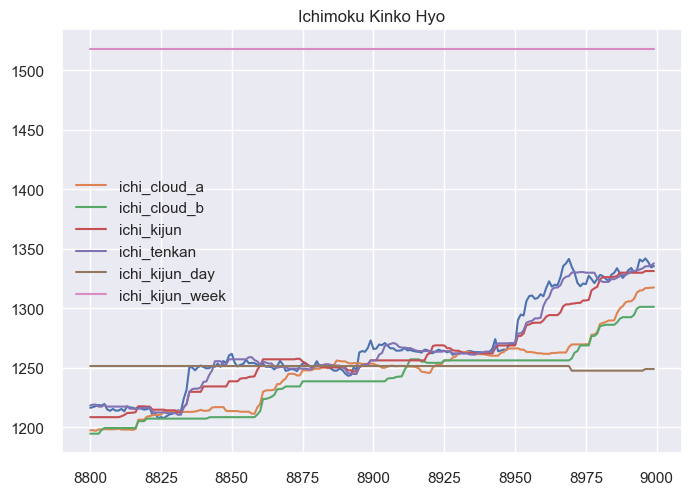

In [40]:
plt.plot(df_eth[-200:].Close)
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [47]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=14).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=14*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=14*24*7).rsi()
    return df_out


df_out = add_rsi(df_eth)
df_out

,Time,Open,High,Low,Close,Volume,date,volume_adi,volume_obv,volume_cmf,...,ichi_cloud_a_day,ichi_cloud_b_day,ichi_kijun_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1640995200000,3676.22,3730.00,3676.22,3723.04,9023.3740,2022-01-01 00:00:00,6.687834e+03,9.023374e+03,0.741168,...,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN,NaN,NaN,NaN
1,1640998800000,3723.04,3748.45,3714.10,3724.89,8997.7569,2022-01-01 01:00:00,3.342816e+03,1.802113e+04,0.185494,...,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN,NaN,NaN,NaN
2,1641002400000,3724.88,3738.47,3722.23,3728.32,5028.4531,2022-01-01 02:00:00,2.085703e+03,2.304958e+04,0.090488,...,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN,NaN,NaN,NaN
3,1641006000000,3728.41,3737.00,3721.84,3723.96,3543.1853,2022-01-01 03:00:00,-4.665126e+02,1.950640e+04,-0.017543,...,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN,NaN,NaN,NaN
4,1641009600000,3723.96,3728.07,3707.24,3708.21,6117.2820,2022-01-01 04:00:00,-6.014062e+03,1.338912e+04,-0.183860,...,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1673377200000,1341.08,1344.04,1338.50,1339.48,22563.0593,2023-01-10 19:00:00,-1.949739e+06,-8.520347e+06,0.139166,...,1249.612500,1376.765000,1247.71,1948.707500,2391.145000,1518.16,1213.125,64.270618,54.893736,49.439492
8996,1673380800000,1339.48,1347.69,1335.08,1341.98,22371.3361,2023-01-10 20:00:00,-1.947628e+06,-8.497976e+06,0.105158,...,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125,66.796411,55.059859,49.451858
8997,1673384400000,1341.97,1343.21,1338.76,1339.01,14307.3162,2023-01-10 21:00:00,-1.960328e+06,-8.512283e+06,0.110837,...,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125,61.088208,54.811350,49.437011
8998,1673388000000,1339.00,1339.45,1334.45,1334.46,11972.0830,2023-01-10 22:00:00,-1.972252e+06,-8.524255e+06,0.099342,...,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125,56.708089,54.603890,49.424552


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [ ]:
# TODO calculate CHOP 




VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price
- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [ ]:
# TODO VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# TODO MVRV Z-score


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on each periods



In [ ]:
# TODO : NUPL ? 

Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [ ]:
# TODO : https://api.alternative.me/fng/?limit=370&format=csv



Other indicators : 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago
- STH-MVRV ? equiv to Price / VWAP of the last 6 months
- Dave’s Logarithmic Growth Curve ?

Others tickers:

- open interest 
- US02Y
- ETHBTC
- SP500
- NASDAC
- DXY



US02Y : 

In [91]:
# TODO : with yfinance ?

Open-Interest

In [58]:
df_eth

,Time,Open,High,Low,Close,Volume,date,volume_adi,volume_obv,volume_cmf,...,ichi_kijun,ichi_tenkan,ichi_tenkan_day,ichi_cloud_a_day,ichi_cloud_b_day,ichi_kijun_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week
0,1640995200000,3676.22,3730.00,3676.22,3723.04,9023.3740,2022-01-01 00:00:00,6.687834e+03,9.023374e+03,0.741168,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
1,1640998800000,3723.04,3748.45,3714.10,3724.89,8997.7569,2022-01-01 01:00:00,3.342816e+03,1.802113e+04,0.185494,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
2,1641002400000,3724.88,3738.47,3722.23,3728.32,5028.4531,2022-01-01 02:00:00,2.085703e+03,2.304958e+04,0.090488,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
3,1641006000000,3728.41,3737.00,3721.84,3723.96,3543.1853,2022-01-01 03:00:00,-4.665126e+02,1.950640e+04,-0.017543,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
4,1641009600000,3723.96,3728.07,3707.24,3708.21,6117.2820,2022-01-01 04:00:00,-6.014062e+03,1.338912e+04,-0.183860,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1673377200000,1341.08,1344.04,1338.50,1339.48,22563.0593,2023-01-10 19:00:00,-1.949739e+06,-8.520347e+06,0.139166,...,1329.995,1333.555,1268.955,1249.612500,1376.765000,1247.71,1948.707500,2391.145000,1518.16,1213.125
8996,1673380800000,1339.48,1347.69,1335.08,1341.98,22371.3361,2023-01-10 20:00:00,-1.947628e+06,-8.497976e+06,0.105158,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8997,1673384400000,1341.97,1343.21,1338.76,1339.01,14307.3162,2023-01-10 21:00:00,-1.960328e+06,-8.512283e+06,0.110837,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8998,1673388000000,1339.00,1339.45,1334.45,1334.46,11972.0830,2023-01-10 22:00:00,-1.972252e+06,-8.524255e+06,0.099342,...,1331.385,1336.135,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125


In [80]:
df_eth.iloc[-1]["date"]

Timestamp('2023-01-10 23:00:00')

In [83]:
int(df_eth.iloc[-1]["date"].timestamp()*1000)

1673391600000

In [74]:
type(df_eth.iloc[-1]["date"])

pandas._libs.tslibs.timestamps.Timestamp

In [72]:
df_eth.iloc[-1]["date"].timestamp()

1673391600.0

In [68]:
type(int(df_eth.iloc[-1]["Time"]))

int

In [76]:
pd.Timestamp("2023-01-20 23:00:00").timestamp()

1674255600.0

In [89]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)

On-Chain data : 
  - Market Cap BTC ETH BNB
  - % Staked ETH
  - nb of address with ETH ?

Other infos :   
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [ ]:
# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
# TODO add sin/cos of day/week/month/year/halving cycle (maybe to short if only 2 year) ?
# TODO 

In [79]:
int(pd.Timestamp("2023-01-20 23:00:00").timestamp())

1674255600

In [35]:
df_test = ta.add_all_ta_features(df_eth, "Open", "High", "Low", "Close", "Volume", fillna=True)
print(df_test.shape)
df_test

8800   2023-01-02 16:00:00
8801   2023-01-02 17:00:00
8802   2023-01-02 18:00:00
8803   2023-01-02 19:00:00
8804   2023-01-02 20:00:00
               ...        
8995   2023-01-10 19:00:00
8996   2023-01-10 20:00:00
8997   2023-01-10 21:00:00
8998   2023-01-10 22:00:00
8999   2023-01-10 23:00:00
Name: date, Length: 200, dtype: datetime64[ns]

In [41]:
df_test.columns.to_list()

['Time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'date',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 '

In [44]:
df_test["momentum_rsi"]

0       100.000000
1       100.000000
2       100.000000
3        52.298392
4        18.313576
           ...    
8995     63.624256
8996     65.489364
8997     61.457829
8998     55.791435
8999     56.882902
Name: momentum_rsi, Length: 9000, dtype: float64